In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import category_encoders as ce

from feature_engine.creation import CyclicalTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import PowerTransformer

In [2]:
DATA_PATH = 'data/data_after_EDA.csv'

# Display all of the columns when data are shown
pd.set_option('display.max_columns', 60) 

In [3]:
data =  pd.read_csv(DATA_PATH, sep=',', parse_dates=['doc_date'], low_memory=False)

In [4]:
data

,bill_country,setting_currency_id,shop_basket_id,doc_date,exchange_currency_rate,original_currency_code,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,product_code,catalog_category_id,catalog_brand_id,product_name,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_name_parameterize,category,tree_path,category_name_parameterized,category_status,catalog_segment_id,categories_ancestor_ids,categories_descendant_ids,category_full_name_path,default_warranty_period,brand_name,brand_parameterized,segment_name,segment_parameterized
0,BG,1,1136409,2020-04-26,1.9558,BGN,345.00,18,18,standard,1,standard,5.34,0.28,39848,225542,179.0,145,MC-2,active,83,95.192308,93.653846,93.653846,94.423077,94.277108,True,False,False,False,2.205000,-2.0,False,mc-2,Kapodastre pre gitaru s kovovými strunami,001:001:019:001,kapodastre-pre-gitaru-s-kovovymi-strunami,active,1.0,"{3,4,178}",{},"{Music,Guitars,Capos,""Capo for acoustic guitar""}",24.0,Musedo,musedo,Music,music
1,BG,1,1136409,2020-04-26,1.9558,BGN,345.00,18,18,standard,1,standard,2.91,0.15,140119,305503,762.0,109,TGC026 1m,active,1,0.000000,0.000000,0.000000,0.000000,100.000000,False,False,False,False,1.385000,0.0,False,tgc026-1m,Hotové nástrojové káble,001:005:010:001:001,hotove-nastrojove-kable,active,1.0,"{3,607,760,761}",{},"{Music,""Studio / PA"",Cables,""Complete Cables"",...",24.0,Lewitz,lewitz,Music,music
2,BG,1,1136409,2020-04-26,1.9558,BGN,345.00,18,18,standard,1,standard,0.49,0.03,34663,220357,153.0,13,351 Shape Premium Pick Medium White Moto,active,46,92.258065,93.225806,94.516129,94.193548,94.804348,True,False,False,False,0.164984,303.0,False,351-shape-premium-pick-medium-white-moto,Medium trsátka,001:001:015:002,medium-trsatka,active,1.0,"{3,4,151}",{},"{Music,Guitars,""Guitar Picks"",""Medium Picks""}",24.0,Fender,fender,Music,music
3,BG,1,1136409,2020-04-26,1.9558,BGN,345.00,18,18,standard,1,standard,4.86,0.26,63176,248871,192.0,320,536501 Foot Rest Blue,active,10,92.500000,87.500000,92.500000,90.000000,92.500000,True,False,False,False,3.243455,55.0,False,536501-foot-rest-blue,Gitarové podnožky,001:001:024,gitarove-podnozky,active,1.0,"{3,4}",{},"{Music,Guitars,""Guitar Foot Rest""}",24.0,GEWA,gewa,Music,music
4,BG,1,1136409,2020-04-26,1.9558,BGN,345.00,18,18,standard,1,standard,0.49,0.03,51524,237219,152.0,6,BPK-72-AT Celluloid Pick Thin Abalone,active,0,0.000000,0.000000,0.000000,0.000000,0.000000,True,True,False,False,0.138880,0.0,False,bpk-72-at-celluloid-pick-thin-abalone,Light trsátka,001:001:015:001,light-trsatka,active,1.0,"{3,4,151}",{},"{Music,Guitars,""Guitar Picks"",""Light Picks""}",24.0,Boss,boss,Music,music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005826,PL,12,2633784,2021-08-26,4.5779,PLN,119.24,4,5,standard,1,standard,80.39,0.00,234242,379626,2733.0,6219,Milty Zerostat 3,active,11,0.000000,0.000000,0.000000,0.000000,90.000000,True,False,False,False,50.031875,31.0,False,milty-zerostat-3,Čistiace prostriedky pre LP platne,014:001:005,cistiace-prostriedky-pre-lp-platne,active,16.0,"{3526,2728}",{},"{""LP platne a CD"",""Príslušenstvo pre LP platne...",24.0,Goldring,goldring,LPs and CDs,lps-and-cds
3005827,CZ,4,3416860,2021-08-26,25.5310,CZK,79.82,3,3,standard,1,standard,29.77,9.01,200523,345907,1332.0,1070,Cascais Trunk Navy XL,ended,0,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,False,False,16.250000,0.0,False,cascais-trunk-navy-xl,BOATS - Pánske Nohavice,004:040:002:002,boats-panske-nohavice,active,4.0,"{1327,1328,1330}",{},"{Boats,""Clothing, Shoes, Bags"",Men's,Pants}",2

In [5]:
data.isna().sum()

bill_country                        0
setting_currency_id                 0
shop_basket_id                      0
doc_date                            0
exchange_currency_rate              0
original_currency_code              0
basket_total_price_with_vat         0
count_basket_items                  0
basket_count_products               0
basket_type                         0
item_quantity                       0
item_type                           0
item_unit_price_with_vat            0
item_total_discount_with_vat        0
product_id                          0
product_code                        0
catalog_category_id                 0
catalog_brand_id                    0
product_name                        0
product_status                      0
reviews_count                       0
reviews_average_score_price         0
reviews_average_score_quality       0
reviews_average_score_properties    0
reviews_average_score_overall       0
reviews_average_score               0
is_in_stock 

# 1. Change non-numeric values to numbers

Machine learning models usually work only with numeric values (integers or floats) - that's why we need to change other formats to numbers. 

In [6]:
data.dtypes

bill_country                                object
setting_currency_id                          int64
shop_basket_id                               int64
doc_date                            datetime64[ns]
exchange_currency_rate                     float64
original_currency_code                      object
basket_total_price_with_vat                float64
count_basket_items                           int64
basket_count_products                        int64
basket_type                                 object
item_quantity                                int64
item_type                                   object
item_unit_price_with_vat                   float64
item_total_discount_with_vat               float64
product_id                                   int64
product_code                                 int64
catalog_category_id                        float64
catalog_brand_id                             int64
product_name                                object
product_status                 

At first let's start with breaking down dates to four different columns - we can extract day of the month, day of the week, week, month and year. We will still keep the original datetime column in code, because it can be useful to easier access date (rather then creating it from columns).

In [7]:
years, months, days, weeks, weekdays = [], [], [], [], []
for date in data['doc_date']:
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    weekdays.append(date.weekday())
    weeks.append(date.week)
    
    

data['doc_day'] = days
data['doc_month'] = months
data['doc_year'] = years
data['doc_weekday'] = weekdays
data['doc_week'] = weeks

**The next part is to find columns that already have their natural number representation - i.e. product_name_parameterize is not necesarry column as we have product_id (numeric products identification)**

In [8]:
# rename catalog_COLUMN to COLUMN only so it is easier to understand
data.rename(columns={'catalog_category_id' : 'category_id', 'catalog_segment_id' : 'segment_id', 'catalog_brand_id' : 'brand_id'}, inplace=True)

# rename other id columns with extra words to pure defining id in similar spirit as with catalog
data.rename(columns={'setting_currency_id' : 'currency_id', 'shop_basket_id' : 'basket_id'}, inplace=True)

In [9]:
def leave_only_id_column(df : pd.DataFrame(), id_column : str, other_columns : list, inplace : bool = False) -> pd.DataFrame():
    """
    Function that counts and compares if product_id is proper representation of other given columns. If yes, then drop other columns and leave id only.
    Args
        df - pandas DataFrame containing desired columns
        id_column - main column containing identificator, this column will be the only one remaining
        other_columns - list of other columns, those will be compared and possibly dropped
        inplace - If False, return a copy. Otherwise, do operation inplace and return None.
    Returns
        pd.DataFrame - DataFrame with removed columns in other_columns or None if inplace is True
    """
    id_col_len = len(data[id_column].unique())
    
    unique_combinations = len(df[other_columns + [id_column]].drop_duplicates().index)
    other_cols_string = ''
    for name in other_columns:
        other_cols_string += name+', '
    
    print(f"{id_col_len} - Unique {id_column} amount.")
    print(f"{unique_combinations} - Amount of unique combinations of {id_column} and {other_cols_string}")
    
    missmatches_amount = abs(id_col_len - unique_combinations)
    print(f"{missmatches_amount} - How many missmatches between {id_column} and other columns.")
    
    if missmatches_amount == 0:
        if inplace:
            df.drop(labels=other_columns, inplace=inplace, axis=1)
            return None
        else:
            return df.drop(labels=other_columns, inplace=inplace, axis=1)
        
    else: 
        print('There were missmatches, not dropping any columns.')
        return None

Because each product id represents one product correctly, we can drop product name as well as parameterized product name. \
We can drop product_code as well for the same reason - product id represents same products as product_code but in different encodings.

In [10]:
leave_only_id_column(data, 'product_id', ['product_name', 'product_code'], inplace=True)
print('\n')

leave_only_id_column(data, 'product_id', ['product_name_parameterize'], inplace=True)

165447 - Unique product_id amount.
165447 - Amount of unique combinations of product_id and product_name, product_code, 
0 - How many missmatches between product_id and other columns.


165447 - Unique product_id amount.
165454 - Amount of unique combinations of product_id and product_name_parameterize, 
7 - How many missmatches between product_id and other columns.
There were missmatches, not dropping any columns.


In [11]:
print(data[['product_id' , 'product_name_parameterize']].drop_duplicates().product_id.value_counts().head(10))
data[data[['product_id' , 'product_name_parameterize', 'item_type']].product_id.__eq__(147573)][['product_name_parameterize']].drop_duplicates()

147631    2
147609    2
107679    2
147573    2
103795    2
91810     2
203372    2
104009    1
168354    1
278795    1
Name: product_id, dtype: int64


,product_name_parameterize
45055,47rs-1-38-nylon-jazz-6-pack
1215752,47rs-1-38-nylon-jazz-6-pack-set


In [12]:
data.drop(labels='product_name_parameterize', inplace=True, axis=1)

Product name parameterize has 7 different than unique values. If we look deeper into it we can see that it is only because there is -set added to the end of the name parameterized. This is deprecated way of set selling, since there is now column (item_type) to differentiate between sets and standard items. That's why we can drop product_name_parametereize as well.

Similar to products, there is many alike records in data (columns represented by other column), we can take care of all of them. 

In [13]:
leave_only_id_column(data, 'category_id', ['category', 'category_name_parameterized'], inplace=True)

2455 - Unique category_id amount.
2455 - Amount of unique combinations of category_id and category, category_name_parameterized, 
0 - How many missmatches between category_id and other columns.


In [14]:
leave_only_id_column(data, 'brand_id', ['brand_name', 'brand_parameterized'], inplace=True)

5336 - Unique brand_id amount.
5336 - Amount of unique combinations of brand_id and brand_name, brand_parameterized, 
0 - How many missmatches between brand_id and other columns.


In [15]:
leave_only_id_column(data, 'currency_id', ['original_currency_code'], inplace=True)

10 - Unique currency_id amount.
10 - Amount of unique combinations of currency_id and original_currency_code, 
0 - How many missmatches between currency_id and other columns.


In [16]:
leave_only_id_column(data, 'segment_id', ['segment_parameterized', 'segment_name'], inplace=True)

15 - Unique segment_id amount.
15 - Amount of unique combinations of segment_id and segment_parameterized, segment_name, 
0 - How many missmatches between segment_id and other columns.


In [17]:
leave_only_id_column(data, 'tree_path', ['category_full_name_path'], inplace=True)

2455 - Unique tree_path amount.
2455 - Amount of unique combinations of tree_path and category_full_name_path, 
0 - How many missmatches between tree_path and other columns.


In [18]:
# In tree path we want to keep it separated in two columns for now - categorty_descendants (parents) and category_ancestors (subcategories). We will check for missmatches and drop tree_path if there are none
leave_only_id_column(data, 'tree_path', ['categories_descendant_ids', 'categories_ancestor_ids'])

data.drop(labels='tree_path', axis=1, inplace=True)

2455 - Unique tree_path amount.
2455 - Amount of unique combinations of tree_path and categories_descendant_ids, categories_ancestor_ids, 
0 - How many missmatches between tree_path and other columns.


**Coding remaining string and boolean values to numerics** \
With the usage of replace (booleans) and OrdinalEncounter (strings) we will change values to their representation in numbers.

In [19]:
data.replace([True, False], [1, 0], inplace=True)

In [20]:
columns_to_change = ['bill_country',
 'basket_type',
 'item_type',
 'product_status',
 'category_status']

ce_ordinal = ce.OrdinalEncoder(cols=columns_to_change)
data = ce_ordinal.fit_transform(data)

for mapped in ce_ordinal.fit(data).mapping:
    print(f"Column {mapped['col']} has mapping of:")
    print(f"{mapped['mapping']} \n\n")

Column bill_country has mapping of:
BG      1
CZ      2
AT      3
DK      4
PL      5
HU      6
SI      7
SK      8
RO      9
IE     10
PT     11
HR     12
GB     13
DE     14
FR     15
EL     16
IT     17
NL     18
LV     19
ES     20
FI     21
BE     22
SE     23
EE     24
GR     25
LT     26
LU     27
CH     28
TR     29
UA     30
RS     31
BA     32
NaN    -2
dtype: int64 


Column basket_type has mapping of:
standard            1
internal            2
express_checkout    3
NaN                -2
dtype: int64 


Column item_type has mapping of:
standard           1
set                2
digital_licence    3
NaN               -2
dtype: int64 


Column product_status has mapping of:
active      1
archived    2
ended       3
inactive    4
NaN        -2
dtype: int64 


Column category_status has mapping of:
active      1
inactive    2
NaN        -2
dtype: int64 




Instead of saving full path to category we just want to know how deep given category is and how many subcategories it has. We will convert arrays of ancestors/ descendants into numbers representing amounts of ids in given lists.

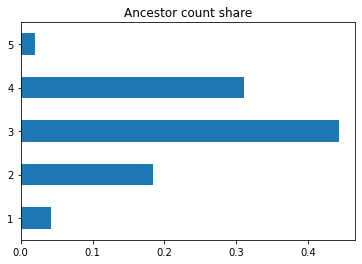

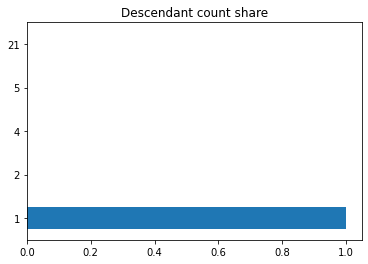

In [21]:
ancestor_count = [len(i.split(',')) for i in data.categories_ancestor_ids]
descendant_count = [len(i.split(',')) for i in data.categories_descendant_ids]

data['ancestor_count'] = ancestor_count
data['descendant_count'] = descendant_count

data.ancestor_count.value_counts(normalize=True).sort_index().plot(kind='barh', title='Ancestor count share')
plt.show()

data.descendant_count.value_counts(normalize=True).sort_index().plot(kind='barh', title='Descendant count share')
plt.show()

data.drop(labels=['categories_ancestor_ids', 'categories_descendant_ids'], axis=1, inplace=True)

# 2. Dealing with outliers

In this part we want to delete outliers, as those might negatively influenece machine learning algorithm. That is why we want to delete at least the first iteration of outliers. There is ~5% values as outliers in the first iteration, which, we consider, is reasonable price to pay for cleaner and more useful data.\
We are considering values further than *3x standard deviations ($\sigma$) from the mean ($\mu$)* as outliers in our preprocessing.

In [22]:
 def delete_outliers(df : pd.DataFrame) -> pd.DataFrame:
    """
    Function deletes rows containing outlier value in any of the columns and returns adjusted dataframe
    Args
        df - dataframe containing columns to check for outliers
    Returns
        DataFrame without outlier values
    """
    for cols in df.columns:    
        # Check for each column in the dataframe    
        data_frame = df[cols]
        data_mean, data_std = np.mean(data_frame), np.std(data_frame)  # Outlier > mean+3*std OR outlier < mean-3*std

        # Outliers percentage definition
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        # Identify and remove outliers
        outliers = [False if x < lower or x > upper else True for x in data_frame] 
            
        # Information for the user about deleting rows based on given column
        if outliers.count(False) > 0:
            print(f'Identified outliers: {outliers.count(False)} in column: {cols}')
        df = df[outliers]

    return df

In [23]:
check_outliers_columns = ['basket_total_price_with_vat', 
                          'count_basket_items', 
                          'basket_count_products', 
                          'item_quantity', 
                          'item_unit_price_with_vat', 
                          'item_total_discount_with_vat', 
                          'reviews_count', 
                          'reviews_average_score_price', 
                          'reviews_average_score_quality', 
                          'reviews_average_score_properties', 
                          'reviews_average_score_overall',
                          'reviews_average_score', 
                          'product_purchase_price',
                          'eshop_stock_count', 
                          'ancestor_count', 
                          'descendant_count']

In [24]:
delete_outliers(data[['basket_total_price_with_vat']])

Identified outliers: 274 in column: basket_total_price_with_vat


,basket_total_price_with_vat
0,345.00
1,345.00
2,345.00
3,345.00
4,345.00
...,...
3005826,119.24
3005827,79.82
3005828,79.82
3005829,25.78


In [25]:
for col in check_outliers_columns:
    data[col] = delete_outliers(data[[col]])
    data.dropna(inplace=True)

Identified outliers: 274 in column: basket_total_price_with_vat
Identified outliers: 15607 in column: count_basket_items
Identified outliers: 11497 in column: basket_count_products
Identified outliers: 4449 in column: item_quantity
Identified outliers: 53359 in column: item_unit_price_with_vat
Identified outliers: 32467 in column: item_total_discount_with_vat
Identified outliers: 30958 in column: reviews_count
Identified outliers: 43446 in column: product_purchase_price
Identified outliers: 16391 in column: eshop_stock_count
Identified outliers: 3678 in column: descendant_count


# 3. Normalization

In [ ]:
min_max_columns = [''


']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[scaled_columns])
scaled = pd.DataFrame(scaled, columns = scaled_columns)

In [50]:
data

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,product_purchase_price,eshop_stock_count,is_fifo,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,ancestor_count,descendant_count
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,2.205000,-2.0,0,1,1.0,24.0,26,4,2020,6,17,3,1.0
1,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,2.91,0.15,140119,762.0,109,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0,0,0,1.385000,0.0,0,1,1.0,24.0,26,4,2020,6,17,4,1.0
2,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,34663,153.0,13,1,46.0,92.258065,93.225806,94.516129,94.193548,94.804348,1,0,0,0.164984,303.0,0,1,1.0,24.0,26,4,2020,6,17,3,1.0
3,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,4.86,0.26,63176,192.0,320,1,10.0,92.500000,87.500000,92.500000,90.000000,92.500000,1,0,0,3.243455,55.0,0,1,1.0,24.0,26,4,2020,6,17,2,1.0
4,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,51524,152.0,6,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0.138880,0.0,0,1,1.0,24.0,26,4,2020,6,17,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005826,5,12,2633784,2021-08-26,4.5779,119.24,4.0,5.0,1,1.0,1,80.39,0.00,234242,2733.0,6219,1,11.0,0.000000,0.000000,0.000000,0.000000,90.000000,1,0,0,50.031875,31.0,0,1,16.0,24.0,26,8,2021,3,34,2,1.0
3005827,2,4,3416860,2021-08-26,25.5310,79.82,3.0,3.0,1,1.0,1,29.77,9.01,200523,1332.0,1070,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,16.250000,0.0,0,1,4.0,24.0,26,8,2021,3,34,3,1.0
3005828,2,4,3416860,2021-08-26,25.5310,79.82,3.0,3.0,1,1.0,1,18.80,6.27,267505,2289.0,1070,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,11.900000,0.0,0,1,9.0,24.0,26,8,2021,3,34,2,1.0
3005829,6,10,3420193,2021-08-26,348.7600,25.78,1.0,1.0,1,1.0,1,23.51,13.48,250170,1270.0,1278,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,14.043333,4.0,0,1,3.0,24.0,26,8,2021,3,34,3,1.0


In [41]:
TODO_TRANSFORM = list(data.columns)
TODO_TRANSFORM.remove('doc_day')
TODO_TRANSFORM.remove('doc_week')
TODO_TRANSFORM.remove('doc_year')
TODO_TRANSFORM.remove('doc_weekday')
TODO_TRANSFORM.remove('doc_month')
TODO_TRANSFORM.remove('doc_date')
TODO_TRANSFORM.remove('is_in_stock')
TODO_TRANSFORM.remove('is_ended')
TODO_TRANSFORM.remove('is_new')
TODO_TRANSFORM.remove('is_fifo')
TODO_TRANSFORM

['bill_country',
 'currency_id',
 'basket_id',
 'exchange_currency_rate',
 'basket_total_price_with_vat',
 'count_basket_items',
 'basket_count_products',
 'basket_type',
 'item_quantity',
 'item_type',
 'item_unit_price_with_vat',
 'item_total_discount_with_vat',
 'product_id',
 'category_id',
 'brand_id',
 'product_status',
 'reviews_count',
 'reviews_average_score_price',
 'reviews_average_score_quality',
 'reviews_average_score_properties',
 'reviews_average_score_overall',
 'reviews_average_score',
 'product_purchase_price',
 'eshop_stock_count',
 'category_status',
 'segment_id',
 'default_warranty_period',
 'ancestor_count',
 'descendant_count']

In [33]:
cyclical = CyclicalTransformer(variables=['doc_day', 'doc_week', 'doc_weekday', 'doc_month'], drop_original=True)
cyclical.fit_transform(data)

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,product_purchase_price,eshop_stock_count,is_fifo,category_status,segment_id,default_warranty_period,doc_year,ancestor_count,descendant_count,doc_day_sin,doc_day_cos,doc_week_sin,doc_week_cos,doc_weekday_sin,doc_weekday_cos,doc_month_sin,doc_month_cos
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,2.205000,-2.0,0,1,1.0,24.0,2020,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-0.5
1,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,2.91,0.15,140119,762.0,109,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0,0,0,1.385000,0.0,0,1,1.0,24.0,2020,4,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-0.5
2,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,34663,153.0,13,1,46.0,92.258065,93.225806,94.516129,94.193548,94.804348,1,0,0,0.164984,303.0,0,1,1.0,24.0,2020,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-0.5
3,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,4.86,0.26,63176,192.0,320,1,10.0,92.500000,87.500000,92.500000,90.000000,92.500000,1,0,0,3.243455,55.0,0,1,1.0,24.0,2020,2,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-0.5
4,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,51524,152.0,6,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0.138880,0.0,0,1,1.0,24.0,2020,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005826,5,12,2633784,2021-08-26,4.5779,119.24,4.0,5.0,1,1.0,1,80.39,0.00,234242,2733.0,6219,1,11.0,0.000000,0.000000,0.000000,0.000000,90.000000,1,0,0,50.031875,31.0,0,1,16.0,24.0,2021,2,1.0,-0.848644,0.528964,-0.776524,-0.630088,1.224647e-16,-1.0,-0.866025,-0.5
3005827,2,4,3416860,2021-08-26,25.5310,79.82,3.0,3.0,1,1.0,1,29.77,9.01,200523,1332.0,1070,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,16.250000,0.0,0,1,4.0,24.0,2021,3,1.0,-0.848644,0.528964,-0.776524,-0.630088,1.224647e-16,-1.0,-0.866025,-0.5
3005828,2,4,3416860,2021-08-26,25.5310,79.82,3.0,3.0,1,1.0,1,18.80,6.27,267505,2289.0,1070,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,11.900000,0.0,0,1,9.0,24.0,2021,2,1.0,-0.848644,0.528964,-0.776524,-0.630088,1.224647e-16,-1.0,-0.866025,-0.5
3005829,6,10,3420193,2021-08-26,348.7600,25.78,1.0,1.0,1,1.0,1,23.51,13.48,250170,1270.0,1278,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,14.043333,4.0,0,1,3.0,24.0,2021,3,1.0,-0.848644,0.528964,-0.776524,-0.630088,1.224647e-16,-1.0,-0.866025,-0.5


# 4. Clustering

In [43]:
# K-MEANS CLUSTERING
# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [56]:
list(data.columns)

['bill_country',
 'currency_id',
 'basket_id',
 'doc_date',
 'exchange_currency_rate',
 'basket_total_price_with_vat',
 'count_basket_items',
 'basket_count_products',
 'basket_type',
 'item_quantity',
 'item_type',
 'item_unit_price_with_vat',
 'item_total_discount_with_vat',
 'product_id',
 'category_id',
 'brand_id',
 'product_status',
 'reviews_count',
 'reviews_average_score_price',
 'reviews_average_score_quality',
 'reviews_average_score_properties',
 'reviews_average_score_overall',
 'reviews_average_score',
 'is_in_stock',
 'is_ended',
 'is_new',
 'product_purchase_price',
 'eshop_stock_count',
 'is_fifo',
 'category_status',
 'segment_id',
 'default_warranty_period',
 'doc_day',
 'doc_month',
 'doc_year',
 'doc_weekday',
 'doc_week',
 'ancestor_count',
 'descendant_count']

In [68]:
kmeansable = data[[
 'item_type',
 'product_id',
 'category_id',
 'brand_id',
 'product_status',
 'reviews_count',
 'reviews_average_score_price',
 'reviews_average_score_quality',
 'reviews_average_score_properties',
 'reviews_average_score_overall',
 'reviews_average_score',
 'is_in_stock',
 'is_ended',
 'is_new',
 'product_purchase_price',
 'eshop_stock_count',
 'is_fifo',
 'category_status',
 'segment_id',
 'default_warranty_period',
 'ancestor_count',
 'descendant_count']].drop_duplicates()

At first we will use kMeans clustering, as agglomerative clustering can be done on large dataset easier than other types.

In [170]:
# Declaring Model
model = KMeans(n_clusters=101)

# Fitting Model
model.fit(kmeansable)

# Prediction on the entire data
all_predictions = model.predict(kmeansable)

kmeansable['kmeans_cluster'] = all_predictions

<BarContainer object of 101 artists>

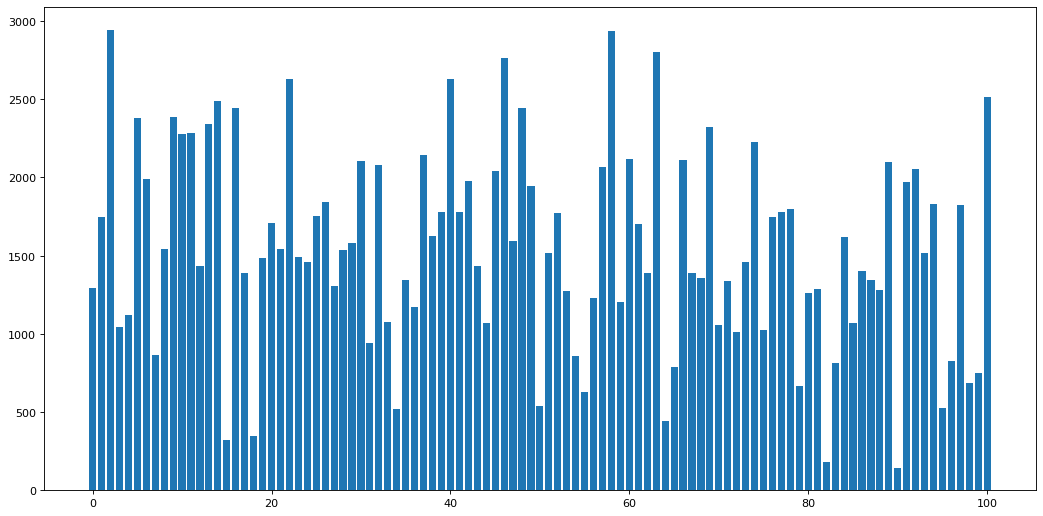

In [171]:
unique, counts = np.unique(all_predictions, return_counts = True)
plt.bar(unique, counts)

In [121]:
from sklearn.cluster import AgglomerativeClustering

In [189]:
cluster_tester = kmeansable[kmeansable.kmeans_cluster.__eq__(2)]

<ipython-input-191-0f77b9dd41c4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_tester['cluster_hierar'] = tmp


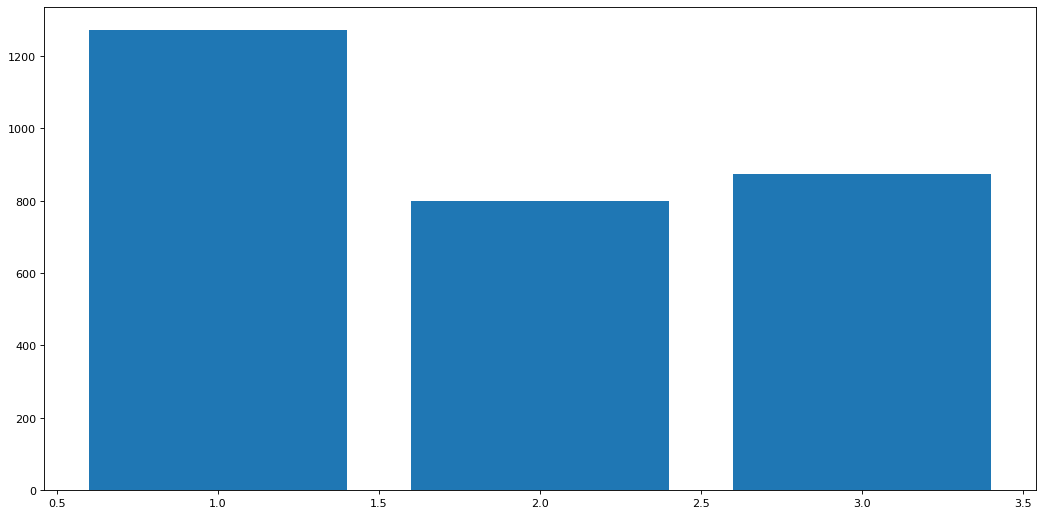

In [191]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage
 
# Use the linkage() function
distance_matrix = linkage(cluster_tester, method = 'ward', metric = 'euclidean')
                                      
tmp = fcluster(distance_matrix, 3, criterion='maxclust')

unique, counts = np.unique(tmp, return_counts = True)
plt.bar(unique, counts)
plt.plot()
cluster_tester['cluster_hierar'] = tmp

In [197]:
cluster_tester

,item_type,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,product_purchase_price,eshop_stock_count,is_fifo,category_status,segment_id,default_warranty_period,ancestor_count,descendant_count,kmeans_cluster,cluster_hierar
31,1,206180,2042.0,1786,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,11.58000,0.0,0,1,16.0,24.0,1,1.0,2,2
118,1,206315,2042.0,1941,1,1.0,0.0,0.0,0.0,0.0,100.0,1,0,0,19.99500,2.0,0,1,16.0,24.0,1,1.0,2,2
169,1,206624,2042.0,2201,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,15.78000,1.0,0,1,16.0,24.0,1,1.0,2,2
220,1,206920,2042.0,2485,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,18.96372,0.0,0,1,16.0,24.0,1,1.0,2,2
221,1,206921,2042.0,2485,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,17.77788,0.0,0,1,16.0,24.0,1,1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994256,1,205715,2030.0,3917,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,8.53000,0.0,0,1,9.0,24.0,2,1.0,2,1
2995408,1,204730,2042.0,3751,1,4.0,100.0,100.0,100.0,100.0,100.0,1,0,0,15.33000,3.0,0,1,16.0,24.0,1,1.0,2,1
2998125,1,207145,2042.0,4755,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,13.92876,0.0,0,1,16.0,24.0,1,1.0,2,1
2999398,1,205558,2042.0,3825,3,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,12.09000,0.0,0,1,16.0,24.0,1,1.0,2,1


In [205]:
data[data.product_id.isin(cluster_tester.product_id.values)]

AttributeError: 'Series' object has no attribute 'product_id'

# IDEAS

In [34]:
"""
TODO 
OPIS TRANSOFMEROV MinMax a Cyclical
OPIS A UPRATANIE CLUSTERINGU
"""

'\nTODO \nOPIS TRANSOFMEROV MinMax a Cyclical\n'

In [35]:
"""
IDEAS
PRIDAJ ROZBITIE NA TRENDY DO Samotneho vyhodnocovania
NAPOCITANIE PREDAJOV PRODUKTOV ZA TYZDEN????
"""

'\nIDEAS\nPRIDAJ ROZBITIE NA TRENDY DO Samotneho vyhodnocovania\nNAPOCITANIE PREDAJOV PRODUKTOV ZA TYZDEN????\n'

In [36]:
tmp = data[['product_id', 'doc_week', 'doc_year', 'item_quantity']].groupby(by=['doc_year', 'doc_week', 'product_id'], as_index=False).sum()

In [37]:
data[['doc_week', 'doc_year']].drop_duplicates()

,doc_week,doc_year
0,17,2020
20,5,2022
42,18,2020
82,20,2020
126,14,2022
...,...,...
52326,19,2020
53688,6,2021
54686,7,2021
60055,29,2021


In [38]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 80

unique, counts = np.unique(tmp.product_id.value_counts().values, return_counts=True)

<BarContainer object of 101 artists>

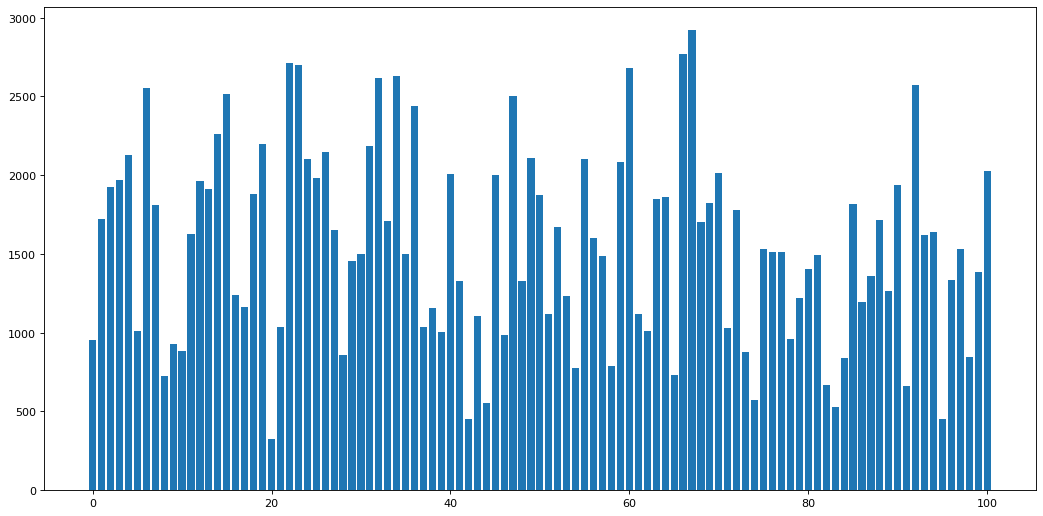

In [167]:
plt.bar(unique, counts)